<a href="https://colab.research.google.com/github/Revanthkrr-hub/Sentiment-Analysis-for-movie-reviews/blob/master/1107178_1dconv_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [163]:
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,f1_score
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")


In [165]:
url_Tr= "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
data = pd.read_csv(url_Tr,sep='\t')
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
train = data[:109242]
test=data[109242:]
df1=train
df2=test

In [0]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [0]:
df1['clean_review']=clean_review(df1.Phrase.values)
df2['clean_review']=clean_review(df2.Phrase.values)


In [169]:
df1.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [0]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                              ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

 # Transforms the data into a bag of words
X_train = count_vec.fit(df1)
X_test= count_vec.transform(df2)

In [171]:
frames = [df1, df2]
df= pd.concat(frames)
df_train=df1
df_test=df2
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(156060, 5)
(109242, 5)
(46818, 5)


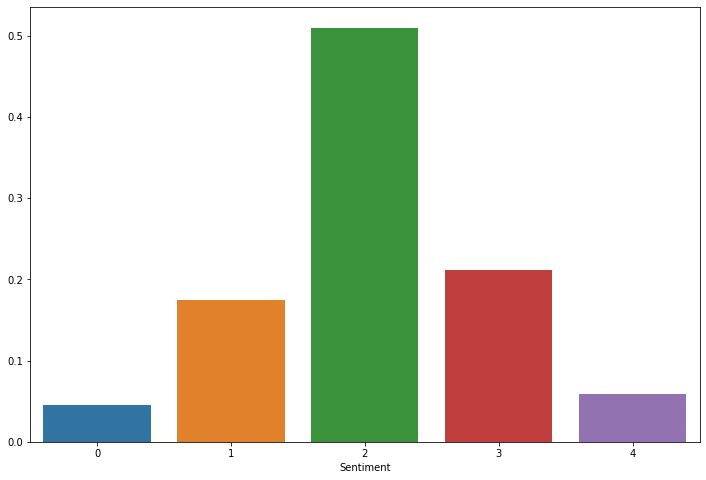

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

dist = df.groupby(["Sentiment"]).size()
dist = dist / dist.sum()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [173]:
X_train=train.clean_review.values
X_test=df_test.clean_review.values
target1=df_train.Sentiment.values
target2=df_test.Sentiment.values

Y_train=to_categorical(target1)
Y_test=to_categorical(target2)

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(109242,) (46818,) (109242, 5) (46818, 5)


In [174]:
# X_train_text = X_train
# X_val_text=X_test
# y_train=Y_train
# y_val=Y_test

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(109242,) (109242, 5)
(46818,) (46818, 5)


In [175]:
all_words=' '.join(X_train)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

11440

In [176]:
r_len=[]
for text in X_train:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

In [0]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 3
num_classes=5

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [179]:
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(109242, 48) (46818, 48)


In [180]:

model= Sequential()
model.add(Embedding(max_features,100,input_length=max_words))
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes,activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 48, 100)           1144000   
_________________________________________________________________
dropout_15 (Dropout)         (None, 48, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                

In [181]:
history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test),epochs=6, batch_size=batch_size, verbose=1)

Train on 109242 samples, validate on 46818 samples
Epoch 1/6
109242/109242 [==============================] - 6s 57us/step - loss: 0.9870 - acc: 0.6073 - val_loss: 1.0004 - val_acc: 0.5981
Epoch 2/6
109242/109242 [==============================] - 5s 47us/step - loss: 0.7656 - acc: 0.6850 - val_loss: 0.9965 - val_acc: 0.5995
Epoch 3/6
109242/109242 [==============================] - 5s 46us/step - loss: 0.6905 - acc: 0.7122 - val_loss: 1.0271 - val_acc: 0.6006
Epoch 4/6
109242/109242 [==============================] - 5s 46us/step - loss: 0.6406 - acc: 0.7307 - val_loss: 1.0648 - val_acc: 0.6005
Epoch 5/6
109242/109242 [==============================] - 5s 46us/step - loss: 0.5995 - acc: 0.7458 - val_loss: 1.1033 - val_acc: 0.5944
Epoch 6/6
109242/109242 [==============================] - 5s 45us/step - loss: 0.5695 - acc: 0.7575 - val_loss: 1.1111 - val_acc: 0.5918


In [0]:
import h5py
from keras.models import load_model
model.save('1107178_1dconv_reg.h5')  
model = load_model('1107178_1dconv_reg.h5')


In [183]:
from sklearn import metrics
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

prediction = model.predict(X_test, verbose=0)
prediction = (prediction > 0.5)
print(metrics.classification_report(Y_test,prediction, digits=3))

Accuracy: 59.18%
              precision    recall  f1-score   support

           0      0.412     0.186     0.256      2186
           1      0.485     0.379     0.426      8777
           2      0.724     0.714     0.719     23110
           3      0.538     0.357     0.429      9853
           4      0.512     0.343     0.411      2892

   micro avg      0.632     0.529     0.576     46818
   macro avg      0.534     0.396     0.448     46818
weighted avg      0.612     0.529     0.562     46818
 samples avg      0.529     0.529     0.529     46818

